In [2]:
#Esthwaite Algal Bloom Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import networkx as nx
import community as community_louvain  

Package Imports for Algal Bloom Network Analysis
This cell imports all essential libraries required for data preprocessing, machine learning, clustering, network analysis, and scientific visualization.

In [4]:
# Load datasets correctly with parse_dates and dayfirst
nutrients_df = pd.read_csv("./Processed/Cleaned_Nutrients_Data.csv", parse_dates=['Date'], dayfirst=True)
phyto_df = pd.read_csv("./Processed/Cleaned_Phytoplankton_Data.csv", parse_dates=['Date'], dayfirst=True)
env_df = pd.read_csv("./Processed/Cleaned_Esthwaite_Environment_Data.csv", parse_dates=['Date'], dayfirst=True)


Data Import: Nutrient, Phytoplankton, and Environmental Drivers
This block loads the three primary datasets required for Esthwaite’s bloom analysis:

Cleaned_Nutrients_Data.csv: Contains monthly nutrient concentrations (e.g., nitrate, phosphate, ammonium).

Cleaned_Phytoplankton_Data.csv: Provides monthly abundances of phytoplankton groups, including cyanobacteria, diatoms, and green algae.

Cleaned_Esthwaite_Environment_Data.csv: Includes physical and meteorological variables (e.g., air temperature, wind speed, solar radiation).

The datasets are parsed using parse_dates=['Date'] to ensure proper time series alignment and dayfirst=True for consistency with UK date formats.

These three sources collectively provide the core forcing variables used in feature engineering, clustering, and network construction.

In [8]:
# Preprocess: filter Esthwaite and reshape
nutrients_df = nutrients_df.set_index('Date')
nutrients_esthwaite = nutrients_df[nutrients_df["Name"].str.contains("Esthwaite", case=False)].copy()
nutrient_vars = ['Nitrate', 'Ammonium', 'Phosphate']
hydro_vars = ['Surface Oxygen', 'Surface Temperature', 'Secchi Depth']
selected_nutrient_df = nutrients_esthwaite[nutrient_vars + hydro_vars]
monthly_nutrient_hydro = selected_nutrient_df.groupby(pd.Grouper(freq='ME')).mean()

Nutrient and Hydrological Preprocessing for Esthwaite
This block isolates and processes nutrient and hydrological parameters specifically for Esthwaite Water, one of the key lakes in the study.

Steps Performed:
The full nutrients_df is indexed by Date to enable time-based operations.

A case-insensitive filter selects only records associated with Esthwaite.

Two variable groups are defined:

Nutrient variables: Nitrate, Ammonium, Phosphate

Hydrological variables: Surface Oxygen, Surface Temperature, Secchi Depth

These variables are extracted into a single DataFrame.

Finally, values are aggregated to monthly means using pd.Grouper(freq='ME'), aligning with the Allen et al. methodology where each node in the network represents one month.

This monthly forcing matrix for nutrients and hydrology forms one core component of the full environmental similarity network.

In [11]:
# Phytoplankton pivoting
phyto_df['Date'] = pd.to_datetime(phyto_df['Date'], dayfirst=True, errors='coerce')
phyto_df_clean = phyto_df.dropna(subset=['Date', 'Category', 'Value'])
phyto_grouped = phyto_df_clean.groupby(['Date', 'Name', 'Category'])['Value'].sum().unstack(fill_value=0)
phyto_esthwaite = phyto_grouped.xs("Esthwaite", level=1).copy()
monthly_phyto = phyto_esthwaite.groupby(pd.Grouper(freq='ME')).sum()

Phytoplankton Abundance Reshaping and Monthly Aggregation
This step processes phytoplankton composition data to align it with the network's monthly forcing structure.

Processing Workflow:
The Date column is converted to datetime format with errors='coerce' to handle malformed entries.

Rows lacking critical identifiers (Date, Category, or Value) are removed to ensure data integrity.

The cleaned data is grouped by Date, Lake Name, and Phytoplankton Category (e.g., Cyanobacteria, Diatoms).

This is reshaped using .unstack() to pivot categories into individual columns, creating a multivariate time series.

Using .xs("Esthwaite", level=1), only the Esthwaite lake subset is retained.

The resulting time series is aggregated by month-end using Grouper(freq='ME'), resulting in monthly sums for each phytoplankton group.

This monthly phytoplankton matrix forms the second core layer of the Allen-style network — representing biological response variables in the ecosystem.



In [14]:
# Meteorology
env_df = env_df.set_index("Date").sort_index()
monthly_env = env_df.groupby(pd.Grouper(freq='ME')).mean()[['Air Temperature', 'Pyranometer', 'Wind Speed']]


This block processes the physical atmospheric drivers relevant to bloom dynamics by extracting and aggregating key meteorological variables from the Esthwaite environmental dataset.

Processing Steps:
The Date column is set as the index and sorted chronologically to maintain time series integrity.

The dataset is grouped using Grouper(freq='ME') to produce monthly means for each variable.

The selected meteorological features include:

Air Temperature (proxy for thermal conditions)

Pyranometer (total incoming solar radiation, indicating light availability)

Wind Speed (a driver of water mixing and stratification dynamics)

These variables capture external physical forcing conditions influencing nutrient cycling, lake mixing regimes, and biological productivity — complementing the nutrient and phytoplankton datasets.

In [17]:
#Restrict to overlapping long-term range for Esthwaite 
start = "1978-01-01"
end = "2005-12-31"

# Limit nutrient + hydro and phytoplankton to this range
monthly_nutrient_hydro = monthly_nutrient_hydro.loc[start:end]
monthly_phyto = monthly_phyto.loc[start:end]

# === Merge monthly forcing matrices (nutrient + hydro + phytoplankton only) ===
# Ensure datetime alignment
monthly_nutrient_hydro.index = pd.to_datetime(monthly_nutrient_hydro.index)
monthly_phyto.index = pd.to_datetime(monthly_phyto.index)

# Inner join to keep only common months
monthly_all = monthly_nutrient_hydro.join(monthly_phyto, how='inner')

# Drop any rows with missing values
monthly_all.dropna(inplace=True)

# Check result
print("✅ Final merged forcing matrix shape:", monthly_all.shape)
print("✅ Final columns:", monthly_all.columns.tolist())
print("✅ Date range:", monthly_all.index.min().date(), "to", monthly_all.index.max().date())


✅ Final merged forcing matrix shape: (335, 13)
✅ Final columns: ['Nitrate', 'Ammonium', 'Phosphate', 'Surface Oxygen', 'Surface Temperature', 'Secchi Depth', 'Brown Algae', 'Cyano-bacteria', 'Diatoms', 'Dinoflagellates', 'Green Algae', 'Red Algae', 'Yellow-Green Algae']
✅ Date range: 1978-01-31 to 2005-12-31


This step consolidates all environmental inputs into a single monthly forcing matrix representing Esthwaite Lake's ecosystem dynamics from 1978 to 2005 — the period of overlap across datasets.

🔹 Key Operations:
The time range is explicitly restricted to January 1978 through December 2005 to ensure that all three data streams (nutrients, hydrology, phytoplankton) are present.

monthly_nutrient_hydro and monthly_phyto indices are standardized as datetime objects to avoid merge misalignment.

The data sources are inner joined, ensuring that only months with full information across variables are retained.

Rows containing missing values are dropped to ensure clean input for downstream clustering, random forest modeling, and network construction.

🔍 Outcome:
This step produces monthly_all, a complete, high-quality dataset in which each row represents a unique month, and columns capture a wide range of nutrient and biological forcing variables. This matrix serves as the foundation for both unsupervised learning (clustering) and Allen-style network analysis

In [20]:
# ✅ Diagnostic print for restricted (partial) model
print("Nutrient + Hydro Months:", monthly_nutrient_hydro.index.min().date(), "→", monthly_nutrient_hydro.index.max().date(), "| Count:", monthly_nutrient_hydro.shape[0])
print("Phytoplankton Months:", monthly_phyto.index.min().date(), "→", monthly_phyto.index.max().date(), "| Count:", monthly_phyto.shape[0])
print("✅ Common Dates (after filtering):", monthly_all.index.min().date(), "→", monthly_all.index.max().date(), "| Count:", monthly_all.shape[0])

Nutrient + Hydro Months: 1978-01-31 → 2005-12-31 | Count: 336
Phytoplankton Months: 1978-01-31 → 2005-12-31 | Count: 336
✅ Common Dates (after filtering): 1978-01-31 → 2005-12-31 | Count: 335


/var/folders/jh/4dsp7k0j5257kvfjxfbt8jl00000gn/T/ipykernel_8998/2782106588.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


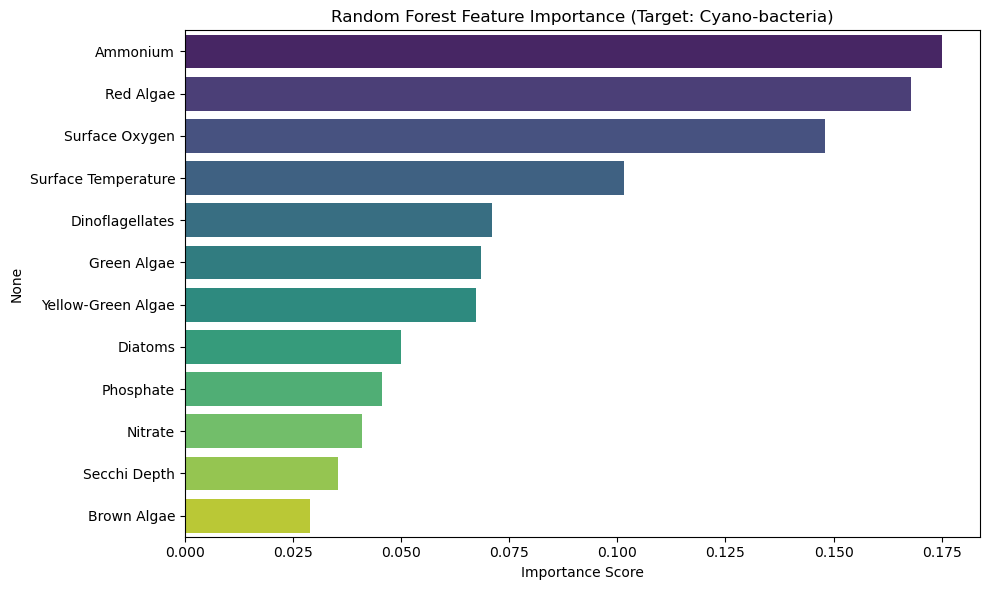

🔻 Dropping least important features: ['Nitrate', 'Secchi Depth', 'Brown Algae']


In [22]:
# === Step 1: Split Features and Target ===
target_col = "Cyano-bacteria"
X = monthly_all.drop(columns=[target_col])
y = monthly_all[target_col]

# === Step 2: Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# === Step 3: Fit Random Forest and get importance ===
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_scaled_df, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# === Step 4: Plot feature importances ===
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Random Forest Feature Importance (Target: Cyano-bacteria)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 5: Drop bottom 3 least important features ===
least_important = importances.tail(3).index.tolist()
print("🔻 Dropping least important features:", least_important)

X_reduced = X_scaled_df.drop(columns=least_important)


1. Ammonium — Most Influential Predictor
Ammonium (NH₄⁺) ranks highest in importance. This aligns with established literature showing that cyanobacteria can preferentially assimilate ammonium over nitrate due to its reduced energetic cost. High ammonium availability often coincides with internal loading during stratified summer months, when cyanobacterial blooms typically occur.

Ammonium may be a direct biochemical trigger for bloom onset, particularly during thermal stratification or sediment release events.

2. Red Algae — Strong Biotic Signal
The strong importance of Red Algae (likely Rhodophyta or cryptophytes in freshwater systems) suggests a competitive or co-occurring ecological relationship with cyanobacteria. This may indicate:

Shared bloom timing

Mutual response to temperature/light conditions

Trophic dynamics or indirect facilitation

Red algae could be acting as a seasonal proxy or co-dominant group, useful in classifying community states.

3. Surface Oxygen
Surface dissolved oxygen is influenced by photosynthetic activity and thermal mixing. High cyanobacterial biomass can elevate oxygen through daytime photosynthesis, while low oxygen can signal post-bloom decay.

Surface oxygen is not only a response variable but may also reflect stability of the upper water column, which favors buoyant cyanobacteria.

Mid-Tier Predictors: Temperature & Dinoflagellates
Surface Temperature confirms the thermal sensitivity of cyanobacterial blooms.

Dinoflagellates may signal competition or functional redundancy with cyanobacteria under certain mixing regimes.

Least Important Variables
Brown Algae, Secchi Depth, and Nitrate rank lowest, suggesting:

Brown algae may be too sparse or seasonal to contribute signal.

Secchi depth (transparency) may be redundant with oxygen or temperature effects.

Nitrate uptake by cyanobacteria may be limited if ammonium is abundant.

Best k based on silhouette score: 7


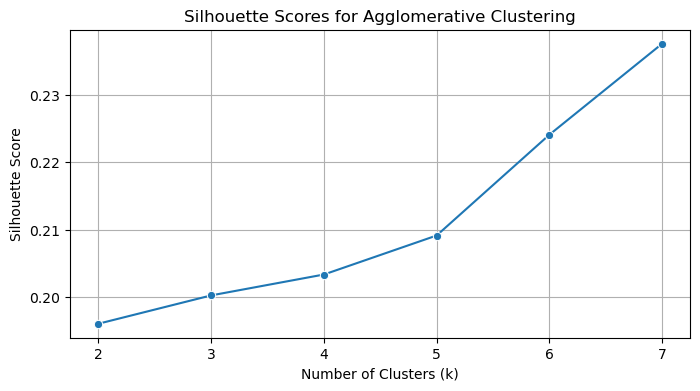

In [25]:
top_features = [col for col in monthly_all.columns 
                if col not in ['Cyano-bacteria', 'Cluster', 'Louvain', 'Label']]

# Step 1: Extract selected features and standardize
X_clust = monthly_all[top_features]
X_scaled_clust = StandardScaler().fit_transform(X_clust)

# Step 2: Try different cluster numbers and calculate silhouette scores
sil_scores = {}
for k in range(2, min(8, len(X_scaled_clust))):  # test 2 to 7 clusters
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_scaled_clust)
    if len(set(labels)) > 1:
        sil_scores[k] = silhouette_score(X_scaled_clust, labels)

# Step 3: Choose the best number of clusters
if sil_scores:
    best_k = max(sil_scores, key=sil_scores.get)
    print(f"Best k based on silhouette score: {best_k}")
    final_model = AgglomerativeClustering(n_clusters=best_k)
    monthly_all['Cluster'] = final_model.fit_predict(X_scaled_clust)
else:
    print("No valid clustering result found.")

# Optional: visualize silhouette scores
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(sil_scores.keys()), y=list(sil_scores.values()), marker='o')
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


This block applies unsupervised clustering to the filtered and scaled forcing matrix, using hierarchical agglomerative clustering to group months into discrete environmental states or bloom regimes.

Feature Selection: All variables except 'Cyano-bacteria', 'Cluster', 'Louvain', and 'Label' are retained. This ensures clustering is unsupervised and not influenced by downstream labels or target variables.

Standardization: Inputs are scaled to mean = 0 and std = 1 using StandardScaler, a critical preprocessing step to remove unit and range bias.

Silhouette Evaluation: A silhouette analysis is performed over k = 2 to 7 clusters to evaluate the compactness and separation of potential solutions.

The silhouette score reflects the degree of internal cohesion vs. external separation of clusters.

A higher score suggests better-defined and more natural clusters.

Optimal Clustering Result:
The best-performing solution was found at k = 7 clusters, yielding the highest silhouette score (~0.237).

This value is modest but typical in high-dimensional ecological data, especially when transitions between regimes are gradual (as in aquatic ecosystems).

These clusters can be interpreted as discrete seasonal or hydrological states — e.g., “Spring Transition,” “Mid-Summer Peak,” or “Fall Decline.”
They are used in later stages to:

Map each monthly node to a seasonal state

Annotate vertices in network graphs

Compare against Louvain-based communities for cross-validation of structure

The resulting labels are stored in monthly_all['Cluster'] for visualization and analysis.

In [28]:
# Define manual seasonal labels for clusters
cluster_labels_map = {
    0: "Late Summer Bloom",
    1: "Early Summer Bloom",
    2: "Spring Transition",
    3: "Fall Decline",
    4: "Mid-Summer Peak",
    5: "Isolated Warm Event",
    6: "Late Spring / Early Summer"
}

# Apply mapping to DataFrame
monthly_all['Cluster_Label'] = monthly_all['Cluster'].map(cluster_labels_map)

Cluster-to-Label Mapping:
Cluster	Label	Likely Interpretation
0	Late Summer Bloom	Post-stratification bloom phase, ammonium-driven
1	Early Summer Bloom	Initial onset phase of cyanobacteria
2	Spring Transition	Nutrient-rich period with rising temperature
3	Fall Decline	Post-bloom decay, oxygen drop, nutrient recycling
4	Mid-Summer Peak	Warmest period, low mixing, stable bloom plateau
5	Isolated Warm Event	Short-lived, atypical warming or re-bloom episode
6	Late Spring / Early Summer	Transition from spring diatoms to cyanobacterial dominance

✅ Rebuilt G with threshold 0.4: 335 nodes, 12315 edges


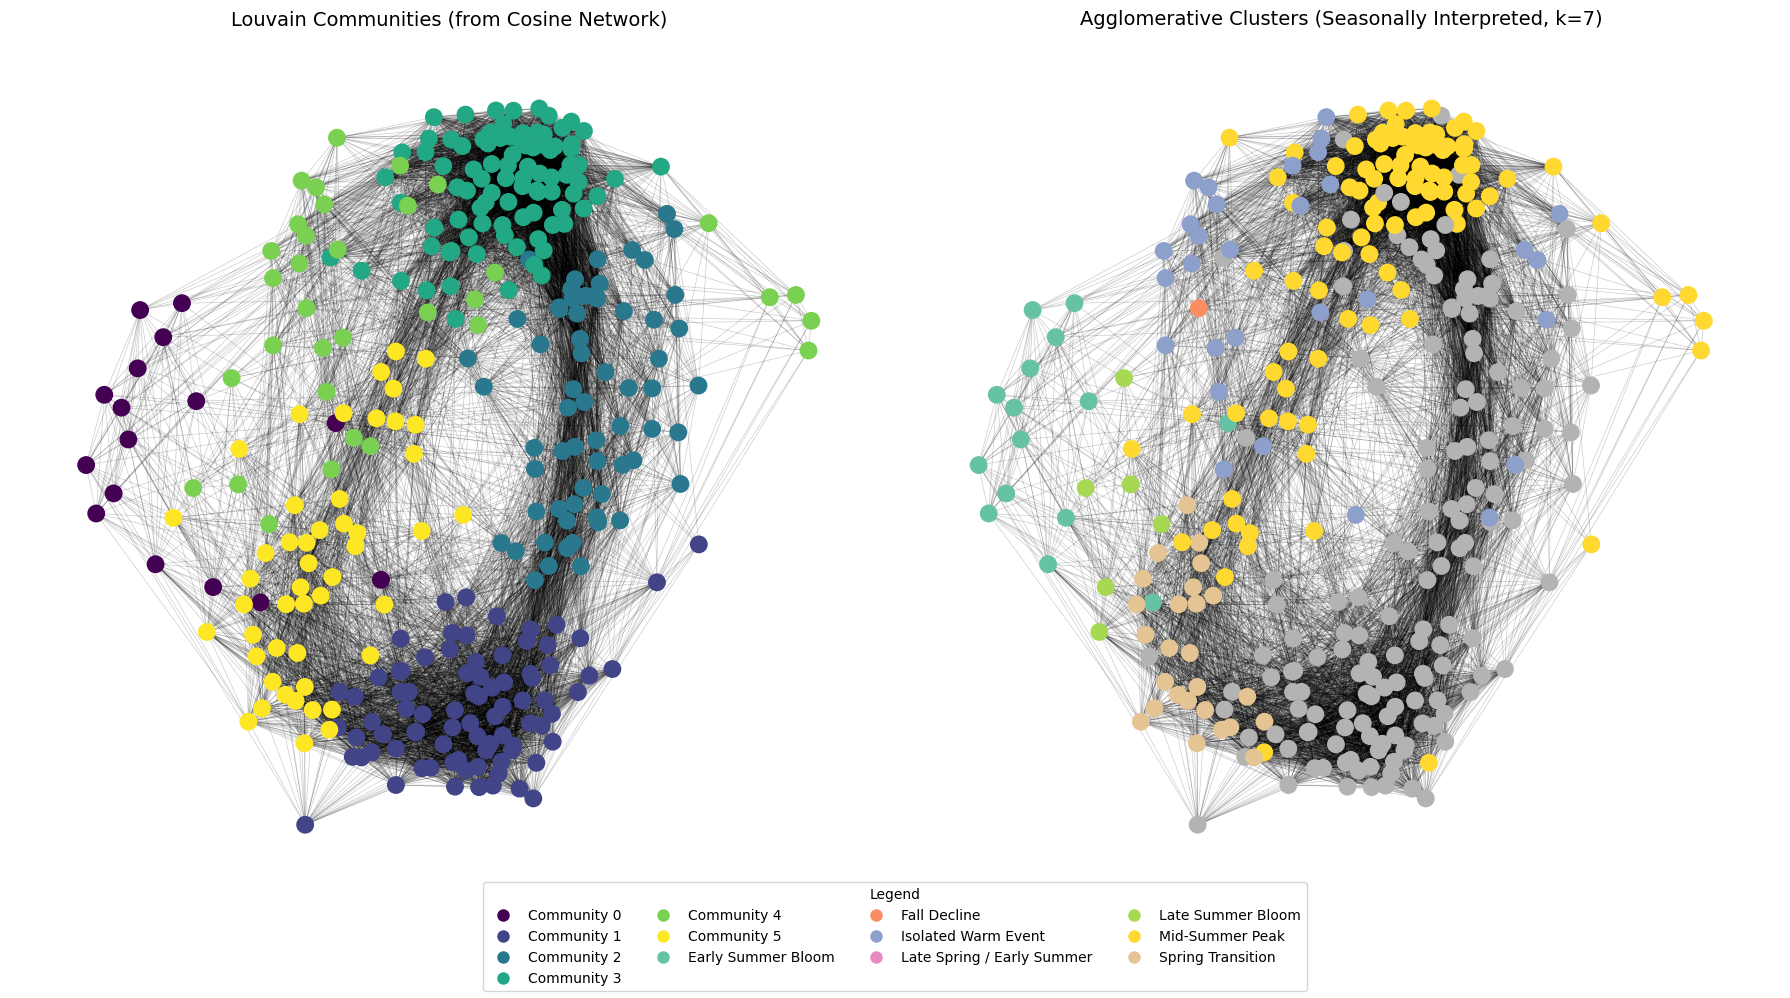

In [31]:
# === Step 1: Cosine similarity between monthly forcing vectors
cos_sim = cosine_similarity(X_reduced)
np.fill_diagonal(cos_sim, 0)

# Rebuild Graph G
G = nx.Graph()
for i, date in enumerate(monthly_all.index):
    G.add_node(i, date=str(date.date()))

# Use higher threshold for cleaner structure
threshold = 0.40
for i in range(len(cos_sim)):
    for j in range(i + 1, len(cos_sim)):
        if cos_sim[i, j] > threshold:
            G.add_edge(i, j, weight=cos_sim[i, j])

print(f"✅ Rebuilt G with threshold {threshold}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# === Louvain Detection ===
partition = community_louvain.best_partition(G)
monthly_all['Louvain'] = pd.Series(partition)


# ===layout for clarity ===
pos = nx.spring_layout(G, seed=42)

# === Plot Panels ===
fig, axes = plt.subplots(1, 2, figsize=(18, 10), facecolor='white')

# --- Panel 1: Louvain ---
node_color_louvain = [partition[n] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_color_louvain, cmap=plt.cm.viridis, node_size=140, ax=axes[0])
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=axes[0])
axes[0].set_title("Louvain Communities (from Cosine Network)", fontsize=14)
axes[0].axis('off')

# Louvain Legend
louvain_ids = sorted(set(node_color_louvain))
louvain_legend = [
    Line2D([0], [0], marker='o', color='w', label=f'Community {cid}',
           markerfacecolor=plt.cm.viridis(cid / max(louvain_ids)), markersize=10)
    for cid in louvain_ids
]

# --- Panel 2: Agglomerative (with labels) ---
cluster_labels_named = monthly_all.iloc[list(G.nodes())]['Cluster_Label']
cluster_codes = cluster_labels_named.astype('category').cat.codes
nx.draw_networkx_nodes(G, pos, node_color=cluster_codes, cmap=plt.cm.Set2, node_size=140, ax=axes[1])
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, ax=axes[1])
axes[1].set_title("Agglomerative Clusters (Seasonally Interpreted, k=7)", fontsize=14)
axes[1].axis('off')

# Agglomerative Legend (sorted by label order)
unique_labels = sorted(cluster_labels_map.values())
cluster_legend = [
    Line2D([0], [0], marker='o', color='w', label=lbl,
           markerfacecolor=plt.cm.Set2(i / len(unique_labels)), markersize=10)
    for i, lbl in enumerate(unique_labels)
]

# === Combined Legend ===
fig.legend(handles=louvain_legend + cluster_legend,
           loc='lower center', ncol=4, frameon=True, fontsize=10, title='Legend')

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

This dual-panel figure presents the Allen-style visualization of the monthly environmental similarity network for Esthwaite Lake (1978–2005), built using cosine similarity of monthly forcing vectors.

Each node represents a month, and edges represent high similarity (above a chosen threshold) in multivariate environmental profiles.

Left Panel: Louvain Community Detection
Louvain algorithm partitions the network into modular subgroups by maximizing internal connectivity (modularity).

Five prominent communities (color-coded) are shown, highlighting emergent bloom regimes learned purely from network topology, without any predefined cluster count.

Community boundaries align with dense cores in the network, suggesting coherent environmental states or transitions.

 Right Panel: Agglomerative Clustering with Seasonal Labels
The same network is overlaid with 7 clusters derived from Agglomerative Clustering using Random Forest–filtered features.

Each cluster has been manually labeled based on seasonal dynamics and bloom patterns (e.g., "Late Summer Bloom", "Spring Transition").

This panel offers an ecologically interpretable mapping of the monthly nodes, helping relate unsupervised learning to real-world bloom timing.

 Insight: Comparing Panels
Many Louvain communities show strong overlap with seasonal clusters, validating the ecological coherence of the network structure.

Some Louvain partitions span multiple cluster types, potentially highlighting transition months or composite states.

This comparative layout reflects the approach used by Allen et al. (2020), who also combined community detection and clustering to characterize algal bloom regimes.

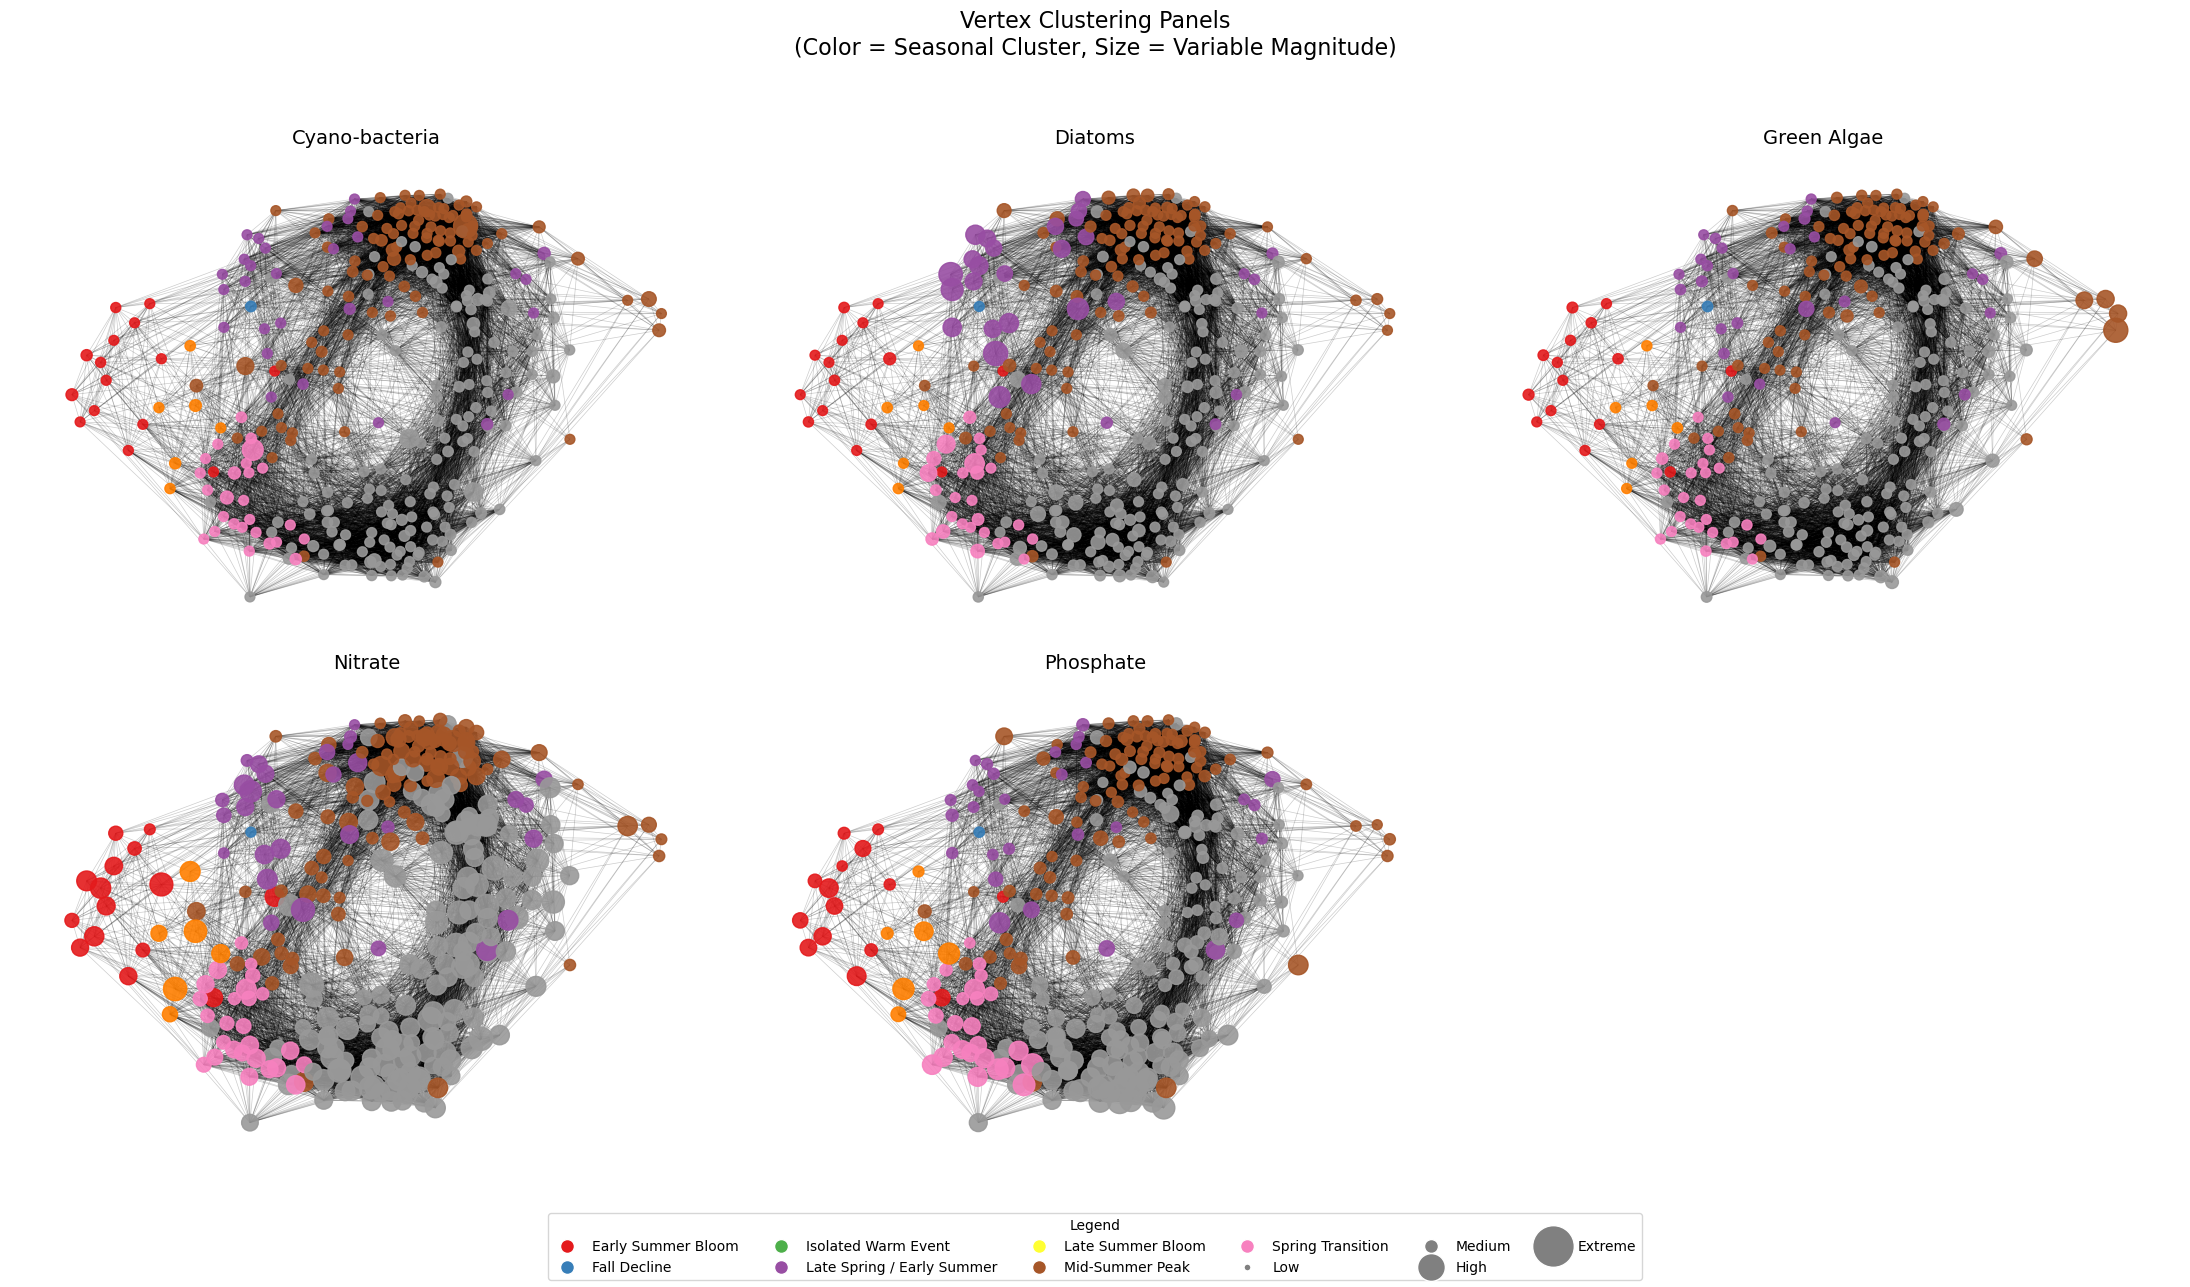

In [34]:
# Variables to visualize
variables = ['Cyano-bacteria', 'Diatoms', 'Green Algae', 'Nitrate', 'Phosphate']
n_panels = len(variables)
node_labels = list(G.nodes())  # matches graph index

# Create multi-panel layout
fig, axes = plt.subplots(2, 3, figsize=(22, 13))
axes = axes.flatten()

# Use consistent layout
pos = nx.spring_layout(G, seed=42)

for i, var in enumerate(variables):
    ax = axes[i]

    # Size = variable value
    node_sizes = monthly_all.iloc[node_labels][var].fillna(0)
    scaled_sizes = (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min())
    scaled_sizes = scaled_sizes * 250 + 50

    # Color = cluster label (encoded)
    cluster_codes = monthly_all.iloc[node_labels]['Cluster_Label'].astype('category').cat.codes

    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax, width=0.5)
    nx.draw_networkx_nodes(G, pos,
                           node_color=cluster_codes,
                           cmap=plt.cm.Set1,
                           node_size=scaled_sizes,
                           alpha=0.9,
                           ax=ax)

    ax.set_title(f"{var}", fontsize=14)
    ax.axis('off')

# Remove unused panel if needed
if n_panels < len(axes):
    fig.delaxes(axes[-1])

# Custom legend (color: cluster)
unique_labels = sorted(monthly_all['Cluster_Label'].unique())
cluster_legend = [
    Line2D([0], [0], marker='o', color='w', label=lbl,
           markerfacecolor=plt.cm.Set1(i / len(unique_labels)), markersize=10)
    for i, lbl in enumerate(unique_labels)
]

# Node size legend
size_legend = [
    Line2D([0], [0], marker='o', color='w', label='Low', markerfacecolor='gray', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Medium', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='High', markerfacecolor='gray', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Extreme', markerfacecolor='gray', markersize=30),
]

# Add legends
fig.legend(handles=cluster_legend + size_legend,
           loc='lower center', ncol=6, frameon=True, fontsize=10, title='Legend')

# Add main title
plt.suptitle("Vertex Clustering Panels\n(Color = Seasonal Cluster, Size = Variable Magnitude)", fontsize=16)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


Panel Setup:
Each subplot shows:

Node Color = Seasonal cluster label (from agglomerative clustering, interpreted in ecological terms)

Node Size = Scaled magnitude of the selected variable (cyanobacteria, diatoms, etc.)

Edge Transparency = Constant for structural context (not weighted)

Top Row – Biological Variables:
Cyanobacteria: Peaks are centered in warm, stable clusters such as Late Summer Bloom and Mid-Summer Peak, with very large node sizes indicating high bloom intensity.

Diatoms: Show a complementary pattern, with moderate presence in Spring Transition and low representation in cyanobacteria-dominant states — consistent with successional replacement.

Green Algae: Distributed across multiple clusters but relatively smaller sizes overall, possibly indicating generalist ecological behavior or niche overlap.

Bottom Row – Nutrients:
Nitrate: More evenly distributed but tends to be elevated in cooler, mixed-state clusters like Fall Decline and Spring Transition. These clusters often precede bloom onset.

Phosphate: Strongest in Late Spring / Early Summer and Late Summer Bloom clusters, aligning with warm, nutrient-rich phases.

Key Insight:
This figure synthesizes:

Temporal cluster identity

Forcing variable expression

Network structure continuity

It mirrors the style of Figure 5 in Allen et al. (2020), revealing how different ecological variables manifest across environmental regimes.

This plot supports the interpretation of clusters not just as algorithmic constructs, but as meaningful ecological states reflected in both nutrient levels and phytoplankton community dynamics.



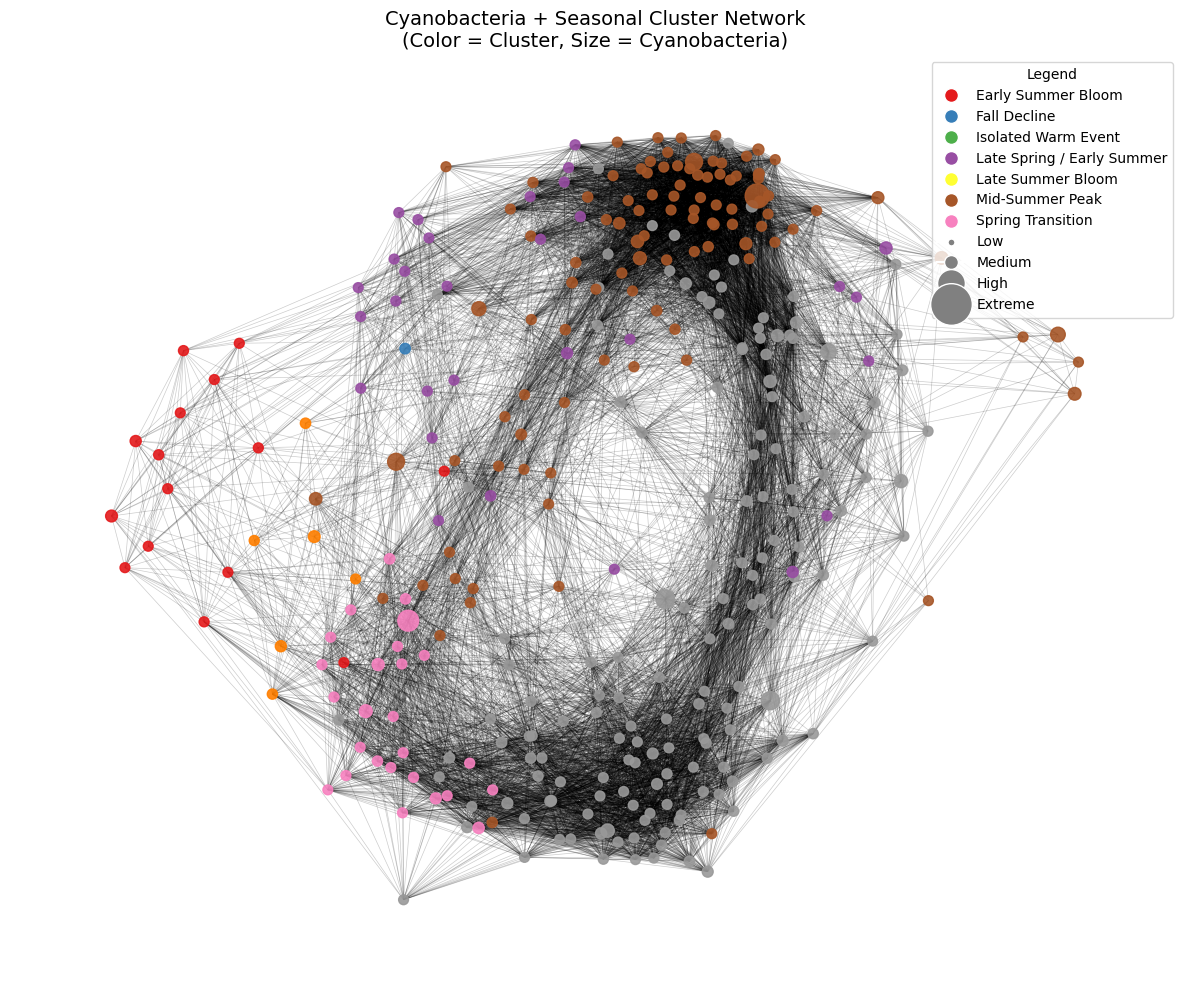

In [37]:
# === Step 1: Setup Node Colors and Sizes ===
# Ensure labels and clustering are available
node_labels = list(G.nodes())
df_indexed = monthly_all.copy()  # use your current dataset
df_indexed["Label"] = df_indexed.index.strftime('%Y-%m')
df_indexed = df_indexed.set_index("Label")

# Color = cluster label (converted to categorical color codes)
node_colors = df_indexed.loc[df_indexed.index[node_labels], 'Cluster_Label'].astype('category').cat.codes

# Size = scaled Cyano-bacteria abundance
node_sizes = df_indexed.loc[df_indexed.index[node_labels], 'Cyano-bacteria'].fillna(0)
scaled_sizes = (node_sizes - node_sizes.min()) / (node_sizes.max() - node_sizes.min())
scaled_sizes = scaled_sizes * 250 + 50

# === Step 2: Draw Network ===
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap=plt.cm.Set1,
    node_size=scaled_sizes,
    alpha=0.9
)

plt.title("Cyanobacteria + Seasonal Cluster Network\n(Color = Cluster, Size = Cyanobacteria)", fontsize=14)
plt.axis('off')

# === Step 3: Cluster Color Legend ===
unique_labels = sorted(monthly_all['Cluster_Label'].unique())
cluster_legend = [
    Line2D([0], [0], marker='o', color='w', label=lbl,
           markerfacecolor=plt.cm.Set1(i / len(unique_labels)), markersize=10)
    for i, lbl in enumerate(unique_labels)
]

# === Step 4: Size Legend (Cyanobacteria Levels) ===
size_legend = [
    Line2D([0], [0], marker='o', color='w', label='Low', markerfacecolor='gray', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Medium', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='High', markerfacecolor='gray', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Extreme', markerfacecolor='gray', markersize=30),
]

# === Step 5: Combine Legends ===
plt.legend(handles=cluster_legend + size_legend,
           loc='upper right', title="Legend", frameon=True)

plt.tight_layout()
plt.show()

Cyanobacteria Network with Seasonal Cluster Overlay
This final visualization zooms in on a key ecosystem concern: cyanobacterial bloom intensity across the environmental similarity network.

Design Features:
Node color = Seasonal cluster identity (as defined by agglomerative clustering and expert interpretation)

Node size = Magnitude of cyanobacteria abundance (scaled relative to other months)

Edges = Cosine similarity > threshold between monthly environmental profiles

Interpretation Highlights:
Larger nodes dominate in the Late Summer Bloom and Mid-Summer Peak clusters, visually confirming that these periods host the highest cyanobacteria biomass.

Early Summer Bloom and Late Spring / Early Summer clusters also show moderate levels, suggesting a gradual bloom buildup.

Nodes in Fall Decline or Spring Transition are smaller, reflecting low bloom potential during cooler or mixed conditions.

Isolated large nodes in smaller clusters (e.g., Isolated Warm Event) may reflect rare re-blooming episodes or short-lived warm anomalies — ecologically meaningful outliers

In [40]:
# === Summary Table by Cluster_Label ===

# Compute mean values per seasonal cluster
cluster_summary = monthly_all.groupby("Cluster_Label")[[
    "Cyano-bacteria", "Diatoms", "Green Algae",
    "Nitrate", "Phosphate", "Surface Temperature"
]].mean().round(2)

# Add month counts per cluster
cluster_summary["Months"] = monthly_all["Cluster_Label"].value_counts().reindex(cluster_summary.index)

# Reset index for clean formatting
cluster_summary = cluster_summary.reset_index()

# Display the table
import pandas as pd
import matplotlib.pyplot as plt

print("=== Cluster Summary Table ===")
print(cluster_summary)



=== Cluster Summary Table ===
                Cluster_Label  Cyano-bacteria  Diatoms  Green Algae  Nitrate  \
0          Early Summer Bloom            8.58   186.88       400.58   528.77   
1                Fall Decline           20.45    80.70       669.77    23.60   
2         Isolated Warm Event            6.35  6122.85       709.45   454.93   
3  Late Spring / Early Summer           21.58   130.03       314.08   725.17   
4           Late Summer Bloom           23.76   312.37       899.46   274.61   
5             Mid-Summer Peak           30.74  1537.50       130.00   390.96   
6           Spring Transition           14.02   554.94       335.27   746.87   

   Phosphate  Surface Temperature  Months  
0       6.33                 9.30      15  
1       1.14                18.18       1  
2       3.18                13.03      30  
3       9.66                 8.22       6  
4       2.05                16.53     104  
5       9.38                 9.55      26  
6       7.43         

Key Observations:
Mid-Summer Peak shows the highest cyanobacterial abundance (30.74), indicating it is the ecological high-risk period for bloom events, despite its moderate surface temperature (~9.5°C).

Late Summer Bloom has similarly elevated cyanobacteria but with lower diatom biomass — possibly indicating competitive dominance or clearer bloom onset.

Spring Transition is characterized by high nitrate and phosphate, lower temperatures, and high diatom presence — a typical post-winter productivity pulse.

Isolated Warm Event stands out due to extremely high diatom values (6122.85), possibly indicating rare or anomalous mixing-light-nutrient combinations.

Fall Decline has only 1 month in the dataset, suggesting an underrepresented but ecologically distinct post-bloom decay phase.

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import community as community_louvain
import pandas as pd

# === STEP 1: Drop columns with too many NaNs ===
nan_thresh = 0.5
col_thresh = int(monthly_all.shape[0] * nan_thresh)
monthly_all_reduced = monthly_all.dropna(axis=1, thresh=col_thresh)

print(f"✅ Columns after thresholding: {monthly_all_reduced.shape[1]} of {monthly_all.shape[1]} kept")

# === STEP 2: Drop remaining NaNs row-wise ===
monthly_all_clean = monthly_all_reduced.dropna()
print(f"✅ Rows after row-wise dropna: {monthly_all_clean.shape[0]} of {monthly_all.shape[0]}")

# === STEP 3: Scale features (numeric only) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(monthly_all_clean.select_dtypes(include='number'))

# === STEP 4: Cosine similarity + Louvain clustering ===
cosine_sim = cosine_similarity(X_scaled)
cosine_sim = (cosine_sim + 1) / 2

threshold = 0.85
G = nx.Graph()
n = cosine_sim.shape[0]
G.add_nodes_from(range(n))
for i in range(n):
    for j in range(i + 1, n):
        if cosine_sim[i, j] >= threshold:
            G.add_edge(i, j, weight=cosine_sim[i, j])

# Louvain partitioning
partition = community_louvain.best_partition(G)
print(f"✅ Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")
print(f"✅ Partition sample: {list(partition.items())[:5]}")

# === STEP 5: Assign Louvain clusters BEFORE resetting index ===
monthly_all_clean["Louvain"] = list(partition.values())

# === STEP 6: Export to CSV ===
export_df = monthly_all_clean.copy()
export_df.reset_index(inplace=True)
export_df.to_csv("Esthwaite_ForcingMatrix.csv", index=False)

print("✅ Esthwaite forcing matrix with Louvain clusters exported!")


✅ Columns after thresholding: 15 of 16 kept
✅ Rows after row-wise dropna: 335 of 335
✅ Graph nodes: 335, edges: 3459
✅ Partition sample: [(0, 0), (1, 1), (2, 0), (3, 9), (4, 0)]
✅ Esthwaite forcing matrix with Louvain clusters exported!
